# Imports, global params

In [1]:
from ddsp import DDSP, AudioDataset, CLAPLoss
from ddsp.callbacks import BetaWarmupCallback
from ddsp.utils import find_checkpoint

from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from IPython.display import display
from IPython.display import Audio

from torch.utils.data import DataLoader, random_split
import lightning as L
import torch
torch.set_float32_matmul_precision('medium')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_device('cuda')

from random import randint

import os
import shutil

# Model parameters
# model_name = 'liget'
model_name = 'drums'
fs = 44100
n_signal = 1.5 * fs # 1.5 seconds
training_path_root = '/home/btadeusz/code/ddsp_vae/training/seven-manifolds'
models_path_root = '/home/btadeusz/code/ddsp_vae/models/seven-manifolds'
# dataset_path = '/mnt/mariadata/datasets/seven_manifolds/liget'
dataset_path = '/mnt/mariadata/datasets/seven_manifolds/drums'

# Training dir
training_path = os.path.join(training_path_root, model_name)
synth_output_path = os.path.join(models_path_root, f'{model_name}.ts')


/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# Synth training

In [ ]:
# DDSP parameters
n_filters = 768
n_sines = 0
latent_size = 2

# Training config
warmup_start = 300
warmup_end = 500
beta = 0
max_epochs = 500
learning_rate = 1e-4


# Reinitiate the training path
shutil.rmtree(training_path, ignore_errors=True)
os.makedirs(training_path, exist_ok=True)

## Dataset loading

In [ ]:
# Load dataset
dataset = AudioDataset(dataset_path=dataset_path, n_signal=n_signal, sampling_rate=fs)

train_set, val_set = random_split(dataset, [0.9, 0.1], generator=torch.Generator(device='cuda'))
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, generator=torch.Generator(device='cuda'))
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=0, generator=torch.Generator(device='cuda'))

## Model initialisation and training

In [ ]:
# Model
ddsp = DDSP(
  n_filters=n_filters,
  n_sines=n_sines,
  fs=fs,
  latent_size=latent_size,
  learning_rate=learning_rate
).to('cuda')

In [ ]:
# Training

## Callbacks
training_callbacks = []

beta_warmup = BetaWarmupCallback(
  beta=beta,
  start_steps=warmup_start,
  end_steps=warmup_end
)
training_callbacks.append(beta_warmup)

# last_checkpoint_callback = ModelCheckpoint(
#     filename='last',
#     save_top_k=1,  # Save only one file, the most recent one
#     save_last=True  # Always save the model at the end of the epoch
#   )
# training_callbacks.append(last_checkpoint_callback)

# best checkopint callback, given the validation loss
best_checkpoint_callback = ModelCheckpoint(
  filename='best',
  monitor='val_loss',
  mode='min',
  save_top_k=1,  # Save only one file, the best one
)
training_callbacks.append(best_checkpoint_callback)

## Trainer
tb_logger = TensorBoardLogger(training_path_root, name=model_name)

# from lightning.pytorch.profilers import PyTorchProfiler
# profiler = PyTorchProfiler(with_stack=True)

trainer = L.Trainer(
  callbacks=training_callbacks,
  max_epochs=max_epochs,
  accelerator='cuda',
  precision=16,
  log_every_n_steps=0,
  logger=tb_logger,
  # profiler=profiler
)

## Start training
trainer.fit(
  model=ddsp,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader,
)

## Model test

In [ ]:
ddsp = ddsp.cuda()
from random import randint
test_x = dataset[randint(0, len(dataset))].unsqueeze(0)

with torch.no_grad():
  test_y = ddsp(test_x)

print("Input")
display(Audio(test_x.squeeze(0).cpu().numpy(), rate=fs))

print("Output")
display(Audio(test_y.squeeze().cpu().numpy(), rate=fs))

## Fine tuning with CLAP loss

In [ ]:
# # Freeze parameters
# ddsp = ddsp.cuda()
# ddsp.train()
# # ddsp.encoder.eval()
# for param in ddsp.encoder.parameters():
#   param.requires_grad = False

# ddsp._recons_loss = CLAPLoss()

# max_epochs = 100
# trainer = L.Trainer(
#   callbacks=training_callbacks,
#   max_epochs=max_epochs,
#   accelerator='cuda',
#   precision=16,
#   log_every_n_steps=0,
#   logger=tb_logger,
#   # profiler=profiler
# )

# trainer.fit(
#   model=ddsp,
#   train_dataloaders=train_loader,
#   val_dataloaders=val_loader,
# )

## Model export

In [ ]:
# Export the model
!python -m cli.export --model_directory {training_path} --output_path  {synth_output_path} --type best

print(f'Model saved at {synth_output_path}')

# Prior training

## Params & configuration

In [2]:
prior_batch_size = 128
d_model = 64 # model dimensionality
sequence_length = 256
nhead = 8
num_layers = 6
prior_epochs = 10000
dataset_stride_factor = 0.01
lr = 1e-5

restart_training = False

In [3]:
from ddsp.prior import Prior, PriorDataset

prior_model_name = f'{model_name}-prior2'

# Training dir
prior_training_path = os.path.join(training_path_root, prior_model_name)

# Reinitiate the training path
if restart_training:
  shutil.rmtree(prior_training_path, ignore_errors=True)
  os.makedirs(prior_training_path, exist_ok=True)

## Prior dataset
The Prior dataset is the same as the audio dataset encoded by the synth encoder into the latent space and arranged into sequences, ready for the sequence prediction training.

In [4]:
prior_dataset = PriorDataset(
  audio_dataset_path=dataset_path,
  encoding_model_path=synth_output_path,
  sequence_length=sequence_length+1,
  sampling_rate=fs,
  device='cuda',
  stride_factor=dataset_stride_factor
)

generator = torch.Generator(device='cuda')
prior_train_set, prior_val_set = random_split(prior_dataset, [0.8, 0.2], generator=generator)
prior_train_loader = DataLoader(prior_train_set, batch_size=prior_batch_size, shuffle=True, generator=generator)
prior_val_loader = DataLoader(prior_val_set, batch_size=prior_batch_size, shuffle=False, generator=generator)

latent_size = prior_dataset[0].shape[-1]

Encoding audio dataset...


/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/module.py:1527: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


## Model initialisation and training

In [5]:
prior = Prior(
  latent_size=latent_size,
  d_model=d_model,
  max_len=sequence_length,
  lr=lr,
  nhead=nhead,
  num_layers=num_layers,
)

prior_logger = TensorBoardLogger(prior_training_path, name=prior_model_name)

prior_callbacks = []
prior_checkpoint_callback = ModelCheckpoint(
  dirpath=prior_training_path,
  filename='best',
  monitor='val_loss',
  mode='min'
)
prior_callbacks.append(prior_checkpoint_callback)

from lightning.pytorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100, stopping_threshold=4e-3)
prior_callbacks.append(early_stopping)


prior_trainer = L.Trainer(
  callbacks=prior_callbacks,
  accelerator='cuda',
  log_every_n_steps=4,
  logger=prior_logger,
  max_epochs=prior_epochs,
)

checkpoint = find_checkpoint(prior_training_path, return_none=True)
# Start training
prior_trainer.fit(
  model=prior,
  train_dataloaders=prior_train_loader,
  val_dataloaders=prior_val_loader,
  ckpt_path=checkpoint
)

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/btadeusz/code/ddsp_vae/training/seven-manifolds/drums-prior2 exists and is not empty.
Restoring states from the checkpoint path at /home/btadeusz/code/ddsp_vae/training/seven-manifolds/drums-prior2/best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                        | Params | Mode 
-----------------------------------------------------------------------------
0 | _projection          | Sequential                  | 328    | train
1 | _encoder             | TransformerEncoder          | 1.7 M  | train
2 | _positional_encoding | LearnablePositionalEncoding | 16.4 K | train
3 | _activation          | ReLU                        | 0      | train
4 | _out                 | Linear                      | 260    | train
5 | _loss                | MSELoss                     | 0      | train
----------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/btadeusz/miniconda3/envs/ddsp/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [6]:
prior_val_loss = prior_trainer.callback_metrics['val_loss']
print(f'Final validation loss: {prior_val_loss}')

KeyError: 'val_loss'

# Unconditional generation

In [17]:
from torch import jit
synth = jit.load(synth_output_path)

In [47]:
prior = prior.cuda()
output_length = 1500
prime = prior_dataset[randint(0, len(prior_dataset))][:sequence_length//2]
sequence = prior.generate(prime, output_length).unsqueeze(0)
mu, logvar = sequence.chunk(2, dim=-1)

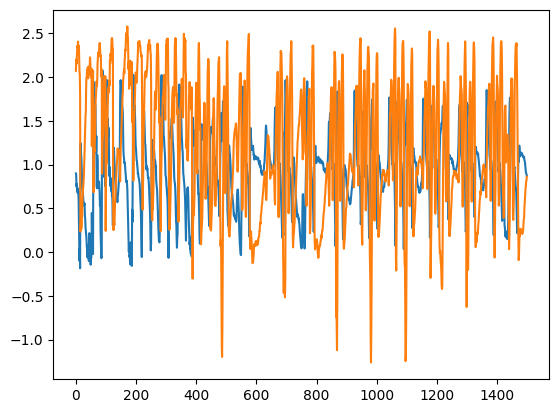

In [48]:
import matplotlib.pyplot as plt

with torch.no_grad():
  latents, _ = synth.pretrained.encoder.reparametrize(mu, logvar)
  audio = synth.decode(latents.permute(0, 2, 1).to('cpu'))

# display latents
plt.plot(latents.squeeze(0).cpu().numpy())
plt.show()

# display audio
audio = audio.cpu().numpy().squeeze()
audio = audio / audio.max()
audio_widget = Audio(audio, rate=fs)
display(audio_widget)